# Preparação do ambiente

## Bibliotecas

In [1]:
import configparser
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tabulate import tabulate
from tqdm.auto import tqdm

from redminelib import Redmine

In [2]:
pd.options.mode.chained_assignment = None

## Constantes e funções auxiliares

In [3]:
NULL_STRING = '#NULLO#'
FILE_SAMPLES = '../datasets/label_issues/20240423/results/samples.parquet'
FILE_SAMPLES_RESULTS = '../datasets/label_issues/20240423/results/samples_results.parquet'
FILE_LABELS = '../datasets/label_issues/20240423/results/issues.csv'
FILE_CREDS = '../creds.ini'
FILE_RESULTS_REPORT = '../datasets/label_issues/20240423/results/report.xlsx'

In [4]:
creds = configparser.ConfigParser()
creds.read(FILE_CREDS)
redmine_url = creds['FISCALIZA']['redmine_url']
redmine_api_key = creds['FISCALIZA']['redmine_api_key']

In [5]:
def parse_issue(issue):
    issue_attrs = ['id', 'tracker', 'status', 'closed_on', 'subject', 'assigned_to']
    issue_results = {}
    for attr in issue_attrs:
        issue_results[attr] = str(issue[attr])

    custom_fields = list(issue.custom_fields.values_list())
    for _, field, value in custom_fields:
        issue_results[field] = str(value)

    return issue_results

In [99]:
def plot_donut(labels,values,title,startangle=30, colors=None):
    fig, ax = plt.subplots(figsize=(5, 3), subplot_kw=dict(aspect="equal"))
    
    wedges, texts = ax.pie(values, wedgeprops=dict(width=0.5), colors=colors, startangle=startangle)
    
    bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")
    
    kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props,
              zorder=0, va="center")
    
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)

    label_completed = '{:.2f}%'.format(values[0]/values.sum()*100)
    ax.annotate(label_completed,xy=(0,0),horizontalalignment='center', verticalalignment='center')
    
    ax.set_title(title)
    plt.show()

# Carga e prepação dos dados

## Carga da amostra

In [7]:
df_samples = pd.read_parquet(FILE_SAMPLES)

columns_to_keep = ['marketplace','nome','desc','Título']
df_samples = df_samples[columns_to_keep]

columns_to_keep = ['marketplace','nome','desc','subject']
df_samples.columns = columns_to_keep

df_samples

,marketplace,nome,desc,subject
0,mercadolivre,Streaming Box S Tucson 2018 A 2022 Carplay 4g ...,STREAMING BOX S - 2GB RAM | 32GB ARMAZENAMENTO...,LABEL_PACP_2024_00000001
1,magalu,Smartphone Motorola Moto G52 XT2221-1 Dual Sim...,Fotografia profissional no seu bolsoDescubra i...,LABEL_PACP_2024_00000002
2,mercadolivre,Notebook Dell Latitude 7490 I5 8ª Ger Ddr4 16g...,Os produtos da Dell destacam-se por oferecer s...,LABEL_PACP_2024_00000003
3,amazon,"Mini rede sem fio, placa de rede sem fio USB 3...",,LABEL_PACP_2024_00000004
4,magalu,"Fone Bluetooth TWS Kaidi KD-771 - 5.1, Touch, ...","Fone Bluetooth Tws, Kaidi Kd-771, Bluetooth 5....",LABEL_PACP_2024_00000005
...,...,...,...,...
21511,amazon,CAIXA ACUSTICA PCX6500,,LABEL_PACP_2024_00021512
21512,amazon,Conector de cauda de celular 10 pcs carregando...,"[De alta qualidade] 100% nova fábrica, segura...",LABEL_PACP_2024_00021513
21513,amazon,Avantree Medley Clear - Fones de ouvido sem fi...,,LABEL_PACP_2024_00021514
21514,amazon,"Hilitand Adaptador sem fio, placa de rede sem ...",,LABEL_PACP_2024_00021515


## Carga dos dados extraídos

In [8]:
df_issues = pd.read_parquet(FILE_SAMPLES_RESULTS)
df_closed_issues = df_issues[df_issues['status']=='Concluída']
df_open_issues = df_issues[df_issues['status']!='Concluída']

last_closed = df_issues['closed_on'].max()

df_resumo = df_issues[['id','status']].groupby('status').count()
df_resumo.loc['Total'] = df_resumo.sum()
print(tabulate(df_resumo))
print(f'Última atualização em: {last_closed} UTC')

df_issues

------------------  -----
Concluída             645
Responder pesquisa  20872
Total               21517
------------------  -----
Última atualização em: 2024-05-02 20:59:30 UTC


,id,tracker,status,closed_on,subject,assigned_to,Unidade de Lotação,Título bem elaborado?,Título identifica o produto?,Descrição bem elaborada?,Descrição identifica produto?,É passível homologação?,É transmissor de RF,Qual o tipo do produto?
0,125707,Rotulagem de Dados,Concluída,2024-04-29 14:36:47,LABEL_PACP_2024_00021516,Maxwel de Souza Freitas,UO021,1,1,Sim,Sim,Sim,Sim,Drone
1,125708,Rotulagem de Dados,Responder pesquisa,NaT,LABEL_PACP_2024_00021505,Maxwel de Souza Freitas,UO021,,,,,,,
2,125709,Rotulagem de Dados,Responder pesquisa,NaT,LABEL_PACP_2024_00021506,Maxwel de Souza Freitas,UO021,,,,,,,
3,125710,Rotulagem de Dados,Responder pesquisa,NaT,LABEL_PACP_2024_00021507,Maxwel de Souza Freitas,UO021,,,,,,,
4,125711,Rotulagem de Dados,Responder pesquisa,NaT,LABEL_PACP_2024_00021508,Maxwel de Souza Freitas,UO021,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21512,147227,Rotulagem de Dados,Responder pesquisa,NaT,LABEL_PACP_2024_00002556,Cesar Alexandre Parazi,FIGF,1,1,,Anúncio não possui descrição,Não,Não,Outro tipo/categoria (não listada acima)
21513,147228,Rotulagem de Dados,Concluída,2024-04-29 19:12:23,LABEL_PACP_2024_00002557,Cesar Alexandre Parazi,FIGF,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Não,Não,Outro tipo/categoria (não listada acima)
21514,147229,Rotulagem de Dados,Responder pesquisa,NaT,LABEL_PACP_2024_00002558,Cesar Alexandre Parazi,FIGF,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Não,Não,Outro tipo/categoria (não listada acima)
21515,147230,Rotulagem de Dados,Concluída,2024-04-29 19:01:56,LABEL_PACP_2024_00002559,Cesar Alexandre Parazi,FIGF,1,0,Não,Não,Não,Não,Outro tipo/categoria (não listada acima)


## Atualização dos dados do Fiscaliza

**Atenção**
Essa operação pode demorar até 10 minutos para ser executada

In [76]:
%%time
redmine = Redmine(redmine_url,key=redmine_api_key)

# filter issues closed from the last closed_on day in actual dataframe 
last_closed_on = df_issues.closed_on.max().strftime('%Y-%m-%d')
last_closed_on = f'>={last_closed_on}'
closed_issues = redmine.issue.filter(project_id=184, status_id='closed', closed_on=last_closed_on)

# uncomment following lines to get all issues
# closed_issues = redmine.issue.filter(project_id=184, status_id='*')

df_closed_issues = pd.DataFrame([parse_issue(issue) for issue in closed_issues])
df_closed_issues['closed_on'] = pd.to_datetime(df_closed_issues['closed_on'],errors='coerce')

df_issues = pd.concat([df_issues, df_closed_issues])
df_issues = df_issues.drop_duplicates(subset='id',keep='last')
df_issues = df_issues.sort_values(by='id').reset_index(drop=True)

df_issues.to_parquet(FILE_SAMPLES_RESULTS)

map_status = {'Concluída': 'Fechada', 'Responder pesquisa': 'Aberta'}
df_resumo = df_issues[['id','status']]
df_resumo['status'] = df_resumo['status'].map(map_status)
df_resumo = df_resumo.groupby('status').count()
df_resumo.loc['Total'] = df_resumo.sum()

print('Total de tarefas atualizadas:',len(df_closed_issues),'\n')
print(tabulate(df_resumo))
print(f'Última atualização em: {last_closed} UTC')

Total de tarefas atualizadas: 131 

-------  -----
Aberta   20720
Fechada    797
Total    21517
-------  -----
Última atualização em: 2024-05-03 UTC
CPU times: total: 281 ms
Wall time: 4.84 s


## Junção dos dados

In [77]:
df_labels = df_samples.merge(df_issues,on='subject', how='left')
df_labels

,marketplace,nome,desc,subject,id,tracker,status,closed_on,assigned_to,Unidade de Lotação,Título bem elaborado?,Título identifica o produto?,Descrição bem elaborada?,Descrição identifica produto?,É passível homologação?,É transmissor de RF,Qual o tipo do produto?
0,mercadolivre,Streaming Box S Tucson 2018 A 2022 Carplay 4g ...,STREAMING BOX S - 2GB RAM | 32GB ARMAZENAMENTO...,LABEL_PACP_2024_00000001,125728,Rotulagem de Dados,Responder pesquisa,NaT,Aécio Ramires de Mesquita,UO071,,,,,,,
1,magalu,Smartphone Motorola Moto G52 XT2221-1 Dual Sim...,Fotografia profissional no seu bolsoDescubra i...,LABEL_PACP_2024_00000002,125729,Rotulagem de Dados,Responder pesquisa,NaT,Aécio Ramires de Mesquita,UO071,,,,,,,
2,mercadolivre,Notebook Dell Latitude 7490 I5 8ª Ger Ddr4 16g...,Os produtos da Dell destacam-se por oferecer s...,LABEL_PACP_2024_00000003,125730,Rotulagem de Dados,Responder pesquisa,NaT,Aécio Ramires de Mesquita,UO071,,,,,,,
3,amazon,"Mini rede sem fio, placa de rede sem fio USB 3...",,LABEL_PACP_2024_00000004,125731,Rotulagem de Dados,Responder pesquisa,NaT,Aécio Ramires de Mesquita,UO071,,,,,,,
4,magalu,"Fone Bluetooth TWS Kaidi KD-771 - 5.1, Touch, ...","Fone Bluetooth Tws, Kaidi Kd-771, Bluetooth 5....",LABEL_PACP_2024_00000005,125732,Rotulagem de Dados,Responder pesquisa,NaT,Aécio Ramires de Mesquita,UO071,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21512,amazon,Conector de cauda de celular 10 pcs carregando...,"[De alta qualidade] 100% nova fábrica, segura...",LABEL_PACP_2024_00021513,125716,Rotulagem de Dados,Concluída,2024-04-29 19:37:05,Maxwel de Souza Freitas,UO021,1,1,Sim,Sim,Não,Não,Outro tipo/categoria (não listada acima)
21513,amazon,Avantree Medley Clear - Fones de ouvido sem fi...,,LABEL_PACP_2024_00021514,125717,Rotulagem de Dados,Concluída,2024-04-29 18:42:42,Maxwel de Souza Freitas,UO021,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Sim,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)
21514,amazon,"Hilitand Adaptador sem fio, placa de rede sem ...",,LABEL_PACP_2024_00021515,125718,Rotulagem de Dados,Concluída,2024-04-29 18:41:24,Maxwel de Souza Freitas,UO021,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Sim,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)
21515,mercadolivre,Drone Vectron Quadricoptero Tamanho G - Polibrinq,VECTRON QUADRICOPTERO TAMANHO G - POLIBRINQ\nO...,LABEL_PACP_2024_00021516,125707,Rotulagem de Dados,Concluída,NaT,Maxwel de Souza Freitas,UO021,1,1,Sim,Sim,Sim,Sim,Drone


# Análise

## Acompanhamento da execução

In [78]:
df_fiscal = df_labels[df_labels['assigned_to']!='Maxwel de Souza Freitas']
df_fiscal = df_fiscal.pivot_table(index='assigned_to',columns='status',values='id',aggfunc='count')
df_fiscal.index.name = 'Fiscal'
df_fiscal = df_fiscal.fillna(0).astype('int')
df_fiscal['% Conclusão'] = df_fiscal['Concluída']/(df_fiscal.sum(axis=1))
df_fiscal = df_fiscal.sort_values(by='% Conclusão',ascending=False)
df_fiscal = df_fiscal.reset_index()
df_fiscal

status,Fiscal,Concluída,Responder pesquisa,% Conclusão
0,João Luis Alves Tavares,226,798,0.220703
1,Darlan Lima Silva,124,900,0.121094
2,Carlos Juliano Pott,96,928,0.093750
3,Oppenheimer Herbert Hans Medeiros Queiroz,82,942,0.080078
4,Sebastião Rangel do Nascimento Silva,80,944,0.078125
5,Aécio Ramires de Mesquita,68,956,0.066406
6,Marcos Rogerio Gianotto,67,957,0.065430
7,Thiago Antonio Alves,31,993,0.030273
8,José Luciano da Silva,8,1016,0.007812
9,Josias Pereira de Barcelos,4,1020,0.003906


In [79]:
df_unidade = df_labels[df_labels['assigned_to']!='Maxwel de Souza Freitas']
df_unidade = df_labels.pivot_table(index='Unidade de Lotação',columns='status',values='id',aggfunc='count')
df_unidade = df_unidade.fillna(0).astype('int')
df_unidade['% Conclusão'] = df_unidade['Concluída']/(df_unidade.sum(axis=1))
df_unidade = df_unidade.sort_values(by='% Conclusão',ascending=False)
df_unidade = df_unidade.reset_index()
df_unidade

status,Unidade de Lotação,Concluída,Responder pesquisa,% Conclusão
0,UO073,124,900,0.121094
1,GR05,96,928,0.093750
2,UO112,82,942,0.080078
3,UO062,80,944,0.078125
4,UO071,68,956,0.066406
5,UO072,67,957,0.065430
6,UO021,238,3871,0.057922
7,GR06,8,1016,0.007812
8,GR07,31,4065,0.007568
9,FIGF,3,1021,0.002930


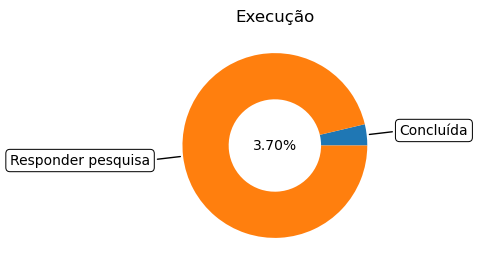

In [100]:
df_count = df_labels[['status','id']].groupby('status').count()
labels = df_count.index.values
values = df_count.values.squeeze()
plot_donut(labels,values,'Execução',startangle=0)

In [ ]:
with pd.ExcelWriter(FILE_RESULTS_REPORT) as writer:
    df_unidade.to_excel(writer, sheet_name='Unidade', index=False)
    df_fiscal.to_excel(writer, sheet_name='Fiscal', index=False)

## Análise e tratamento

In [ ]:

df_labels[(df_labels['Título identifica o produto?']=='1')&(df_labels['É passível homologação?']=='Sim')]